In [48]:
import numpy as np
import scipy as sp 
from numpy.linalg import matrix_power as mp
import matplotlib.pyplot as plt
import matplotlib_settting
from functions import Spectral, polyeig
from scipy.signal import find_peaks


def select_solutions(V,omega, omega_real_range=[0,100], omega_imag_range=None):
    selection = (np.real(omega) > omega_real_range[0]) & (np.real(omega) < omega_real_range[1])
    if omega_imag_range:
        selection = selection & (np.imag(omega) > omega_imag_range[0]) & (np.imag(omega) < omega_imag_range[1])
    return V[:,selection], omega[selection]

def sort_solutions(V,omega):
    index = np.argsort(omega)
    V = V[:,index]
    omega = omega[index]
    return V, omega

def plotting(V,omega, num_eigfuncs=5):
    plt.figure()
    plt.plot(np.real(omega), np.imag(omega), 'o')
    plt.xlabel("$\Re(\omega)$")
    plt.ylabel("$\Im(\omega)$")
    plt.title(f"eigenvalues, $v_0={v0}$")

    plt.figure()
    for i in range(num_eigfuncs):
        v = V[:,i]
        plt.plot(x, np.real(v), '-', color=f"C{i}", label=f"$\omega={omega[i]}$")
        plt.plot(x, np.imag(v), '--', color=f"C{i}")
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"eigenfunctions, $v_0={v0}$")
    plt.legend()

$$ \omega^2v + 2iv_0\omega v' + (1-v_0^2) v'' = 0, v(\pm 1) = 0 $$

$v$ is defined on the integer-grid and the equation is evaluated on half-grid.

$$ \omega^2v_{i+1/2} + 2iv_0\omega (dv/dx)_{i+1/2} + (1-v_0^2) (d^2v/dx^2)_{i+1/2} = 0, v(\pm 1) = 0 $$

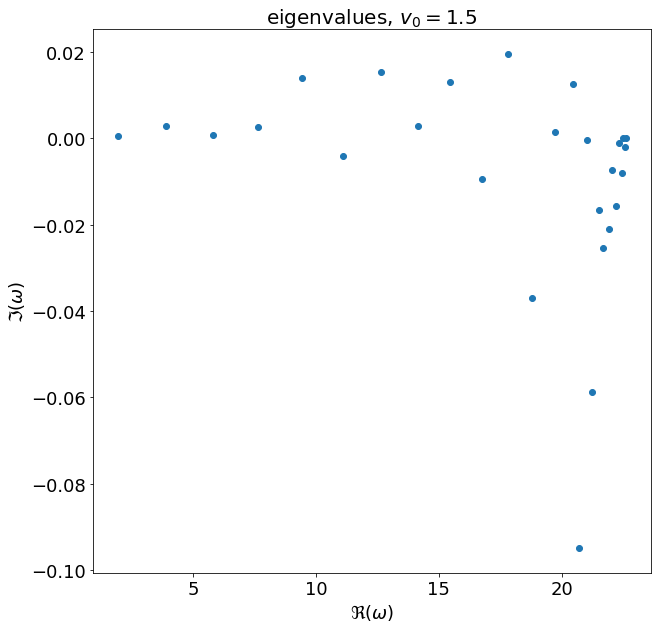

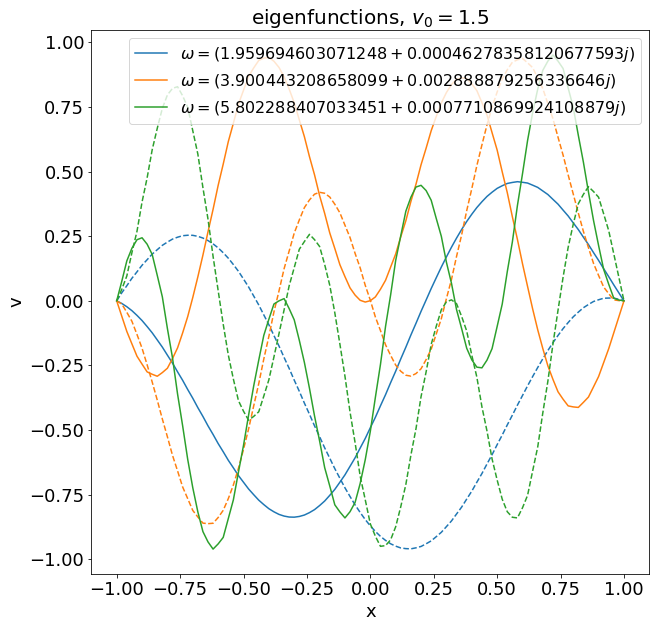

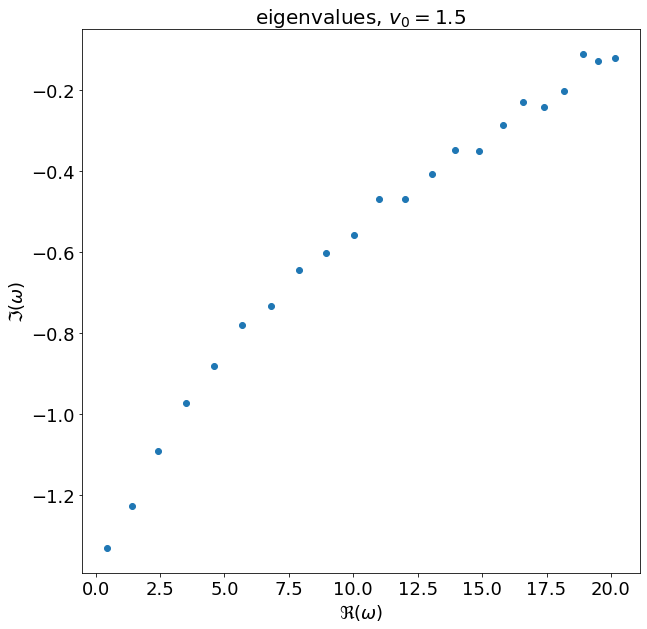

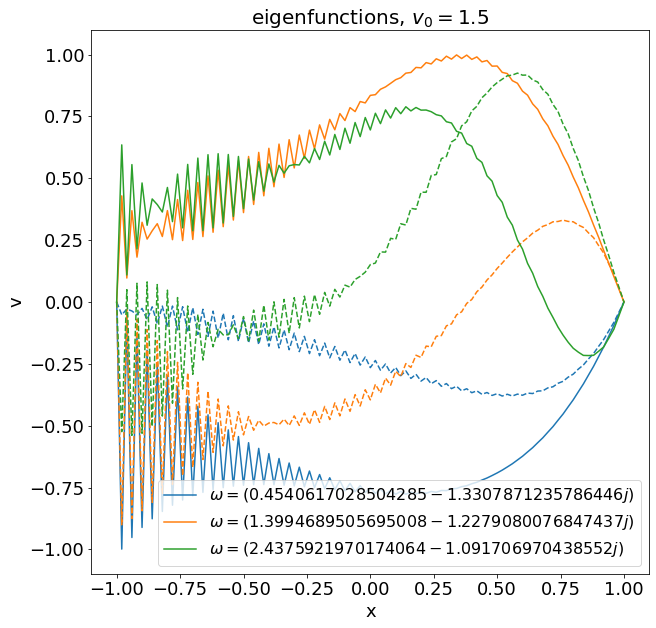

In [15]:
v0 = 1.5
N = 101
spectral = Spectral(N, "symmetric", "FD")
x = spectral.x
h = x[1] - x[0] # the space between nodes are the same for integer and half grid
# the matrix to compute v_{i+1/2} from v_{i}
Mv = np.zeros((N-2,N-2))
for i in range(Mv.shape[0]):
    for j in range(Mv.shape[1]):
        if i == j:
            Mv[i,j] = 0.5 
        elif j == i + 1:
            Mv[i,j] = 0.5

D1 = np.zeros((N-2,N-2))
for i in range(D1.shape[0]):
    for j in range(D1.shape[1]):
        if i == j:
            D1[i,j] = -1
        elif j == i + 1:
            D1[i,j] = 1
D1 /= h

D2 = np.zeros((N-2,N-2))
for i in range(D2.shape[0]):
    if i == 0:
        D2[i,:3] = [-1,-1,1]
    elif i >= D2.shape[0]-2:
        D2[i,-3:] = [1,-1,-1]
    else:
        D2[i,i-1:i+3] = [1,-1,-1,1]
D2 /= 2*h**2



V, omega = polyeig((1-v0**2)*D2, 2j*v0*D1, Mv)
V = np.pad(V, ((1,1),(0,0)), constant_values=0)

V_, omega_ = select_solutions(V,omega, omega_real_range=[0.1,100], omega_imag_range=[-0.1, 0.1])
V_, omega_ = sort_solutions(V_,omega_)
plotting(V_,omega_,num_eigfuncs=3)

V_, omega_ = select_solutions(V,omega, omega_real_range=[0.1,100], omega_imag_range=[-1.5, -0.1])
V_, omega_ = sort_solutions(V_,omega_)
plotting(V_,omega_,num_eigfuncs=3)

# Evaluate on the same grid, but we remove large $k$ modes.

/tmp/ipykernel_428/2460790741.py:26: RuntimeWarning: Mean of empty slice.
  wave_length = np.diff(x[np.isclose(v.real,0)][::2]).mean()
/home/hunt/miniconda3/envs/plasma/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


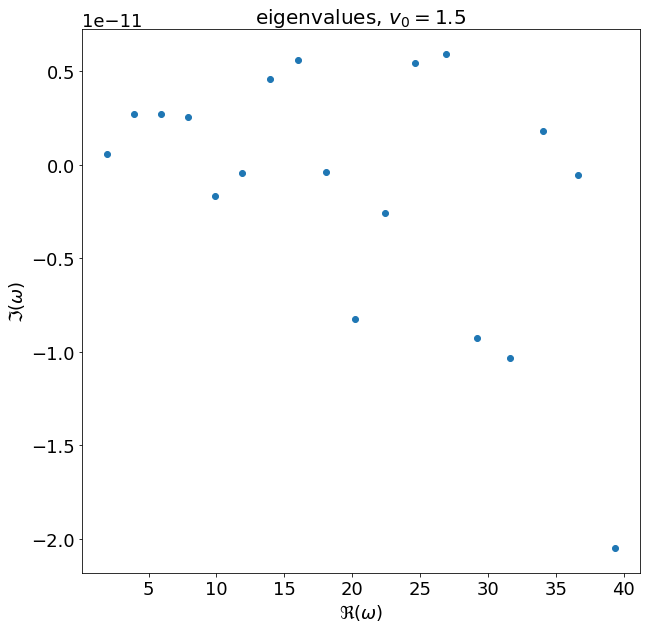

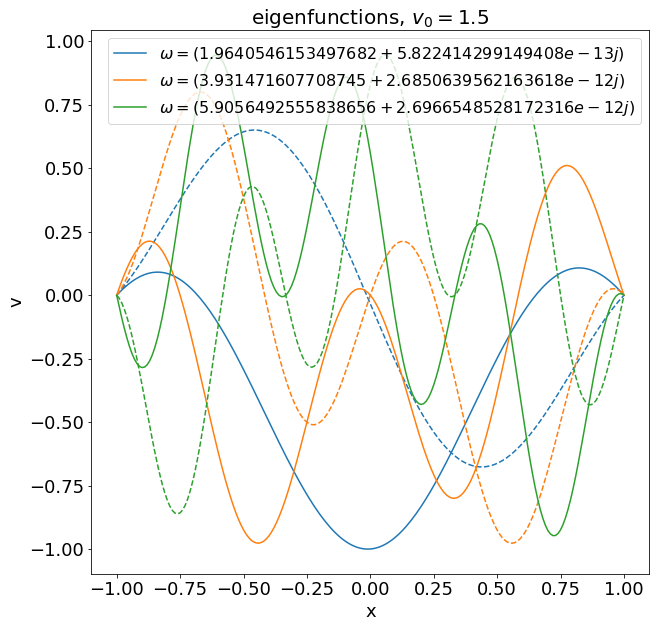

In [76]:
v0 = 1.5
N = 201 # take sufficient points so that we can accurately compute wave number and kill spurious modes
spectral = Spectral(N, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1[1:-1,1:-1]
D2 = spectral.D2[1:-1,1:-1]

V, omega = polyeig((1-v0**2)*D2, 2j*v0*D1, np.eye(N-2))
V = np.pad(V, ((1,1),(0,0)), constant_values=0)

V, omega = select_solutions(V,omega, omega_real_range=[0.1,100])
V, omega = sort_solutions(V,omega)


k_max = 2/h*np.arcsin(1/v0)
V_ = []
omega_ = []
for i in range(omega.size):
    v = V[:,i]
    # calculate k by counting peaks
    pos = find_peaks(v.real)[0]
    wave_length = np.diff(x[pos]).mean()
    k_peak = 2*np.pi/wave_length

    # calculate k by counting zeros
    wave_length = np.diff(x[np.isclose(v.real,0)][::2]).mean()
    k_zero = 2*np.pi/wave_length
    k = max(k_peak, k_zero)
    if k < k_max:
        V_.append(v)
        omega_.append(omega[i])
V_ = np.column_stack(V_)  
omega_ = np.array(omega_)

plotting(V_,omega_,num_eigfuncs=3)

k_peaks = 71.7102670928105
k_zeros = 6.283185307179586


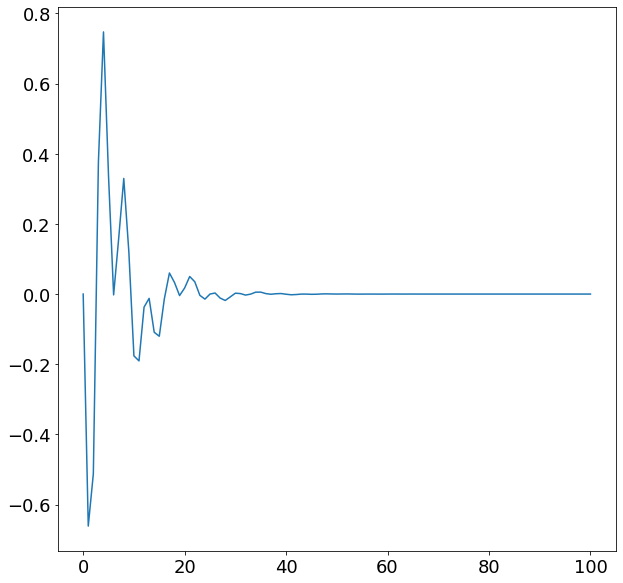

In [74]:
v = V_[:,14]
plt.plot(v.real)
pos = find_peaks(v.real)[0]
wave_length = np.diff(x[pos]).mean()
k = 2*np.pi/wave_length
print("k_peaks =", k)

wave_length = np.diff(x[np.isclose(v,0)][::2]).mean()
k = 2*np.pi/wave_length
print("k_zeros =", k)

/tmp/ipykernel_428/3572517134.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/v.real)
/tmp/ipykernel_428/3572517134.py:2: RuntimeWarning: divide by zero encountered in true_divide
  pos = find_peaks(1/v.real)[0]


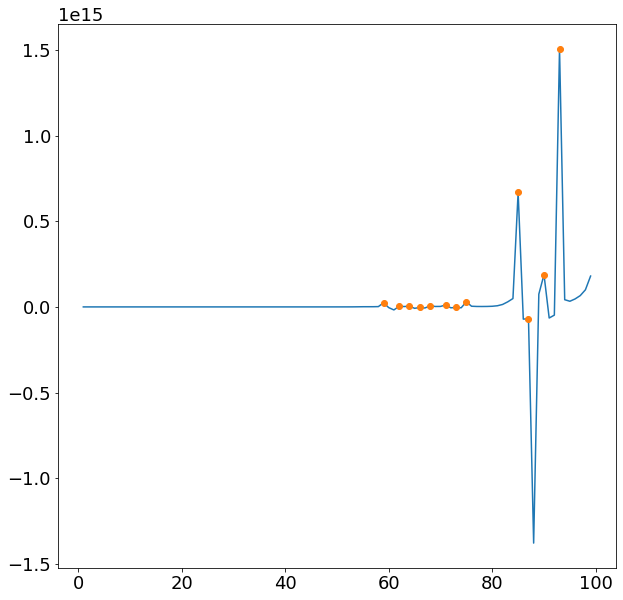

In [60]:
plt.plot(1/v.real)
pos = find_peaks(1/v.real)[0]
plt.plot(pos, 1/v.real[pos], "o")

$$ \omega^2v + 2iv_0\omega v' + (1-v_0^2) v'' = 0, v(\pm 1) = 0 $$

Let $u = \omega v$, then the equation becomes
$$
\begin{align*}
u &= \omega v \\
-(1-v_0^2)v'' -2iv_0u' &= \omega u
\end{align*}
$$

We can define $u$ and $v$ either on integer grid (denoted as f) or half-grid (denoted as s). Futhermore, we can evaluate the equation on either the same grid as the function is defined on (denoted as G) or on the opposite grid (denoted as H).

Notation: 
$$ (g_v, g_u, P_1, P_2) $$
means the variable $v$ is defined on grid $g_v\in \{f,s\}$, $u$ is defined on $g_u \in \{f,s\}$. Equation 1 is evaluated on grid $P_1\in \{G,H\}$, and equation 1 is evaluated on grid $P_2\in \{G,H\}$.

# (f,f,H,H)
$v$ and $u$ are defined on integer-grid, all equations are evaluated on half-grid.

$$
\begin{align*}
u_{i+1/2} &= \omega v_{i+1/2} \\
-(1-v_0^2)(d^2v/dx^2)_{i+1/2} -2iv_0(du/dx)_{i+1/2} &= \omega u_{i+1/2}
\end{align*}
$$

$$ 
\begin{bmatrix}
O_{(N-2)\times(N-2)} & M_{(N-2)\times(N-2)} \\ -(1-v_0^2)D^2_{(N-2)\times(N-2)} & -2iv_0 D_{(N-2)\times(N-2)}
\end{bmatrix}
\begin{bmatrix}
v_1\\ ...\\ v_{N-2}\\ u_{1}\\ ...\\ u_{N-2}
\end{bmatrix}
=
\omega
\begin{bmatrix}
M_{(N-2)\times(N-2)} & O_{(N-2)\times(N-2)} \\ O_{(N-2)\times(N-2)} & M_{(N-2)\times(N-2)}
\end{bmatrix}
\begin{bmatrix}
v_1\\ ...\\ v_{N-2}\\ u_{1}\\ ...\\ u_{N-2}
\end{bmatrix}
$$

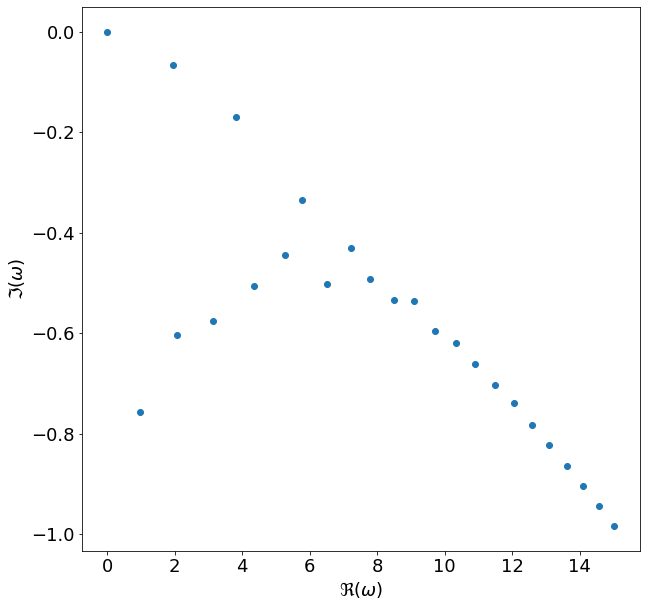

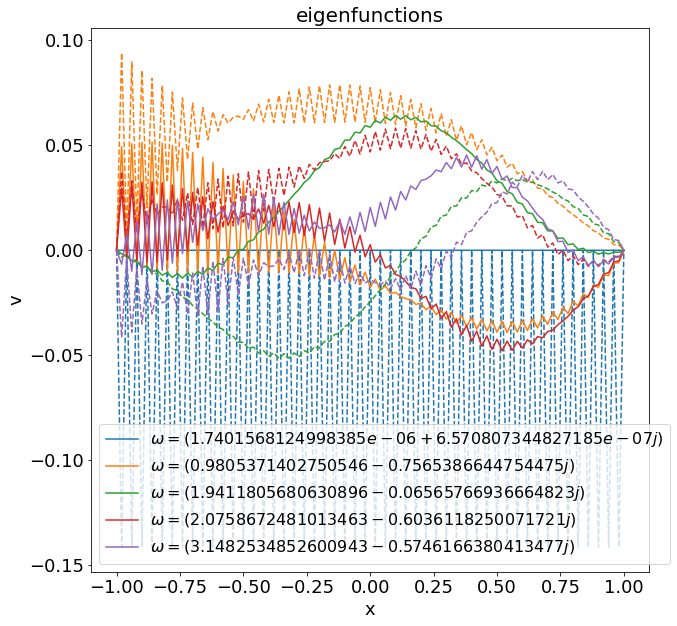

In [27]:
v0 = 1.5
N = 101
spectral = Spectral(N, "symmetric", "FD")
x = spectral.x
h = x[1] - x[0] # the space between nodes are the same for integer and half grid
# the matrix to compute u_{i+1/2} from v_{i}
M = np.zeros((N-2,N-2))
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if i == j:
            M[i,j] = 0.5 
        elif i == j + 1:
            M[i,j] = 0.5

D1 = np.zeros((N-2,N-2))
for i in range(D1.shape[0]):
    for j in range(D1.shape[1]):
        if i == j:
            D1[i,j] = -1
        elif j == i + 1:
            D1[i,j] = 1
D1 /= h

D2 = np.zeros((N-2,N-2))
for i in range(D2.shape[0]):
    if i == 0:
        D2[i,:3] = [-1,-1,1]
    elif i == D2.shape[0]-1:
        D2[i,-4:] = [1,-1,-1,1]
    elif i == D2.shape[0]-2:
        D2[i,-3:] = [1,-1,-1]
    else:
        D2[i,i-1:i+3] = [1,-1,-1,1]
D2 /= 2*h**2

B = np.block([[M, np.zeros((N-2,N-2))],[np.zeros((N-2,N-2)), M]])
A = np.block([[np.zeros((N-2, N-2)), M],[-(1-v0**2)*D2, -2j*v0*D1]])

omega, V = sp.linalg.eig(A,B)

V = V[:N-2,:]
V = np.pad(V, ((1,1),(0,0)), constant_values=0)


V, omega = select_solutions(V,omega,omega_imag_range=[-1,1])
V, omega = sort_solutions(V,omega)
plotting(V,omega)

# (f,s,G,G)
$v$ is defined on integer-grid and $u$ is defined on half-grid, all equations are evaluated on their own grid.

$$
\begin{align*}
u_{i+1/2} &= \omega v_{i} \\
-(1-v_0^2)(d^2v/dx^2)_{i} -2iv_0(du/dx)_{i+1/2} &= \omega u_{i+1/2}
\end{align*}
$$

$$ 
\begin{bmatrix}
O_{(N-2)\times(N-2)} & I_{(N-2)\times(N-1)} \\ -(1-v_0^2)D^2_{(N-1)\times(N-2)} & -2iv_0 D_{(N-1)\times(N-1)}
\end{bmatrix}
\begin{bmatrix}
v_1\\ ...\\ v_{N-2}\\ u_{1/2}\\ ...\\ u_{N-3/2}
\end{bmatrix}
=
\omega
\begin{bmatrix}
I_{(N-2)\times(N-2)} & O_{(N-2)\times(N-1)} \\ O_{(N-1)\times(N-2)} & I_{(N-1)\times(N-1)}
\end{bmatrix}
\begin{bmatrix}
v_1\\ ...\\ v_{N-2}\\ u_{1/2}\\ ...\\ u_{N-3/2}
\end{bmatrix}
$$

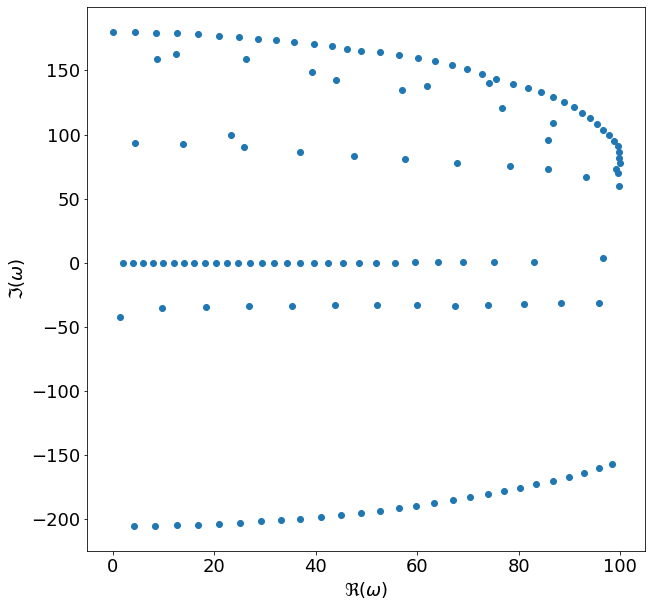

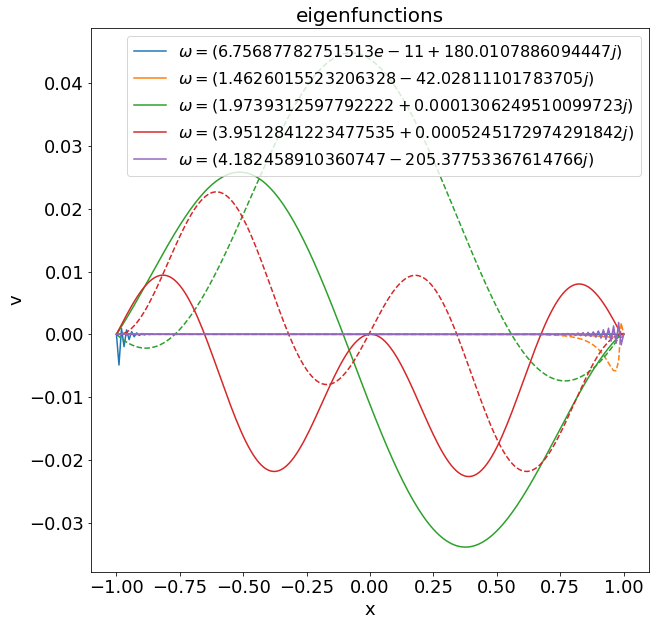

In [25]:
v0 = 1.5
N = 201
spectral = Spectral(N, "symmetric", "FD")
x = spectral.x
D2 = spectral.D2[1:,1:-1] # (N-1,N-2)
D1 = spectral.D1[1:,1:] # (N-1,N-1)

A = np.block([[np.zeros((N-2, N-2)), np.eye(N-1)[:-1,:]],[-(1-v0**2)*D2, -2j*v0*D1]])
B = np.block([[np.eye(N-2), np.zeros((N-2,N-1))],[np.zeros((N-1,N-2)), np.eye(N-1)]])


omega, V = sp.linalg.eig(A,B)

V = V[:N-2,:]
V = np.pad(V, ((1,1),(0,0)), constant_values=0)


V, omega = select_solutions(V,omega)
V, omega = sort_solutions(V,omega)
plotting(V,omega)

# f (s,H,G)

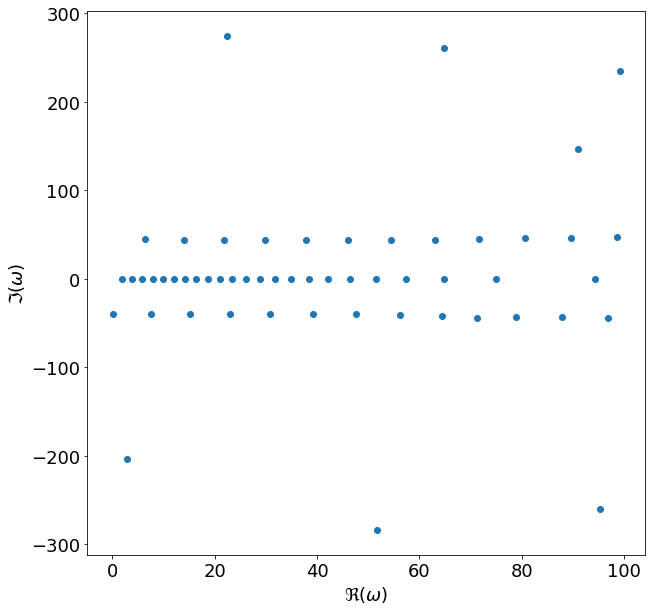

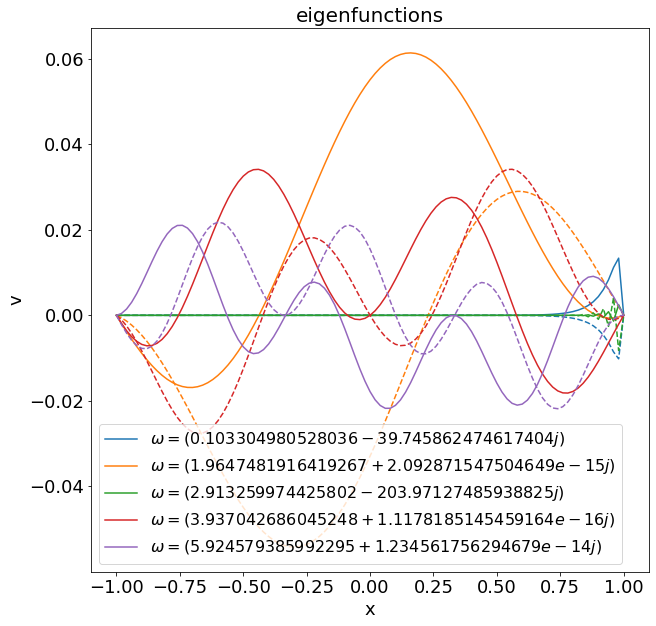

In [ ]:
v0 = 1.5
N = 101
spectral = Spectral(N, "symmetric", "FD")
x = spectral.x
h = x[1] - x[0] # the space between nodes are the same for integer and half grid
# the matrix to compute u_{i+1/2} from v_{i}
Mv = np.zeros((N-1,N-2))
for i in range(Mv.shape[0]):
    for j in range(Mv.shape[1]):
        if i == j:
            Mv[i,j] = 0.5 
        elif i == j + 1:
            Mv[i,j] = 0.5

# the matrix to compute v_{i} from u_{i+1/2}
Mu = np.zeros((N-2,N-1))
for i in range(Mu.shape[0]):
    for j in range(Mu.shape[1]):
        if i == j:
            Mu[i,j] = 0.5 
        elif j == i + 1:
            Mu[i,j] = 0.5

B = np.block([[Mv, np.zeros((N-1,N-1))],[np.zeros((N-2,N-2)), Mu]])


D2 = spectral.D2[1:-1,1:-1] # (N-2,N-2)
D1 = np.zeros((N-2,N-1))
for i in range(D1.shape[0]):
    for j in range(D1.shape[1]):
        if i == j:
            D1[i,j] = -1/h
        elif j == i + 1:
            D1[i,j] = 1/h

A = np.block([[np.zeros((N-1, N-2)), np.eye(N-1)],[-(1-v0**2)*D2, -2j*v0*D1]])

omega, V = sp.linalg.eig(A,B)

V = V[:N-2,:]
V = np.pad(V, ((1,1),(0,0)), constant_values=0)


selection = (np.real(omega) > 0) & (np.abs(np.real(omega))<100)
V = V[:,selection]
omega = omega[selection]

index = np.argsort(omega)
V = V[:,index]
omega = omega[index]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
for i in range(5):
    v = V[:,i]
    plt.plot(x, np.real(v), '-', color=f"C{i}", label=f"$\omega={omega[i]}$")
    plt.plot(x, np.imag(v), '--', color=f"C{i}")
plt.xlabel("x")
plt.ylabel("v")
plt.title("eigenfunctions")
plt.legend()

# f (f,G,H)

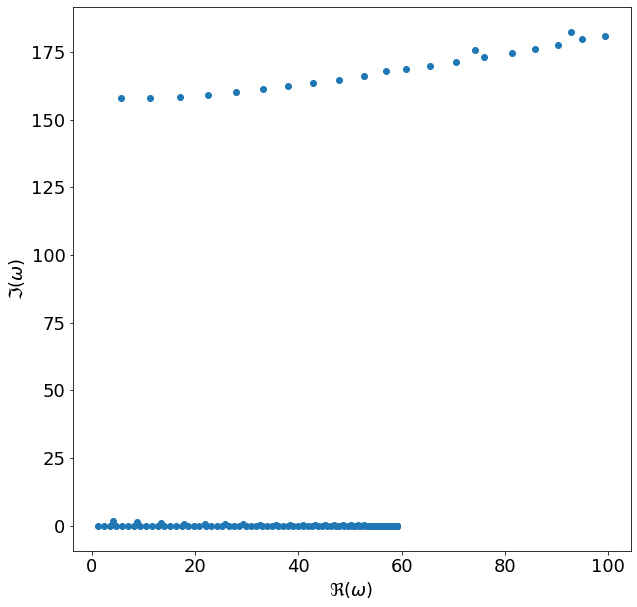

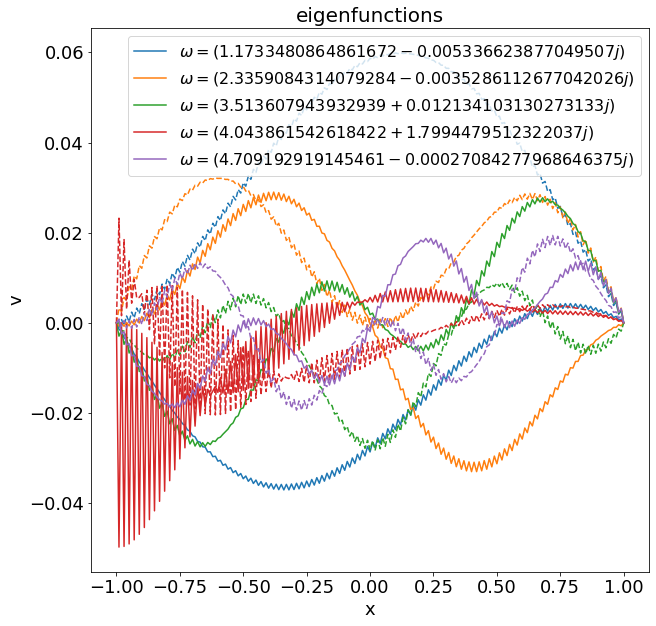

In [ ]:
v0 = 0.5
N = 201
spectral = Spectral(N, "symmetric", "FD")
x = spectral.x
h = x[1] - x[0] # the space between nodes are the same for integer and half grid

# the matrix to compute v_{i} from u_{i+1/2}
Mu = np.zeros((N-2,N-2))
for i in range(Mu.shape[0]):
    for j in range(Mu.shape[1]):
        if i == j:
            Mu[i,j] = 0.5 
        elif j == i + 1:
            Mu[i,j] = 0.5

B = np.block([[np.eye(N-2), np.zeros((N-2,N-2))],[np.zeros((Mu.shape[0],N-2)), Mu]])



D1 = np.zeros((N-2,N-2))
for i in range(D1.shape[0]):
    for j in range(D1.shape[1]):
        if i == j:
            D1[i,j] = -1
        elif j == i + 1:
            D1[i,j] = 1
D1 /= h

D2 = np.zeros((N-2,N-2))
for i in range(D2.shape[0]):
    if i == 0:
        D2[i,:3] = [-1,-1,1]
    elif i == D2.shape[0]-1:
        D2[i,-4:] = [1,-1,-1,1]
    elif i == D2.shape[0]-2:
        D2[i,-3:] = [1,-1,-1]
    else:
        D2[i,i-1:i+3] = [1,-1,-1,1]
D2 /= 2*h**2

A = np.block([[np.zeros((N-2, N-2)), np.eye(N-2)],[-(1-v0**2)*D2, -2j*v0*D1]])

omega, V = sp.linalg.eig(A,B)

V = V[:N-2,:]
V = np.pad(V, ((1,1),(0,0)), constant_values=0)


selection = (np.real(omega) > 1) & (np.abs(np.real(omega))<100)
V = V[:,selection]
omega = omega[selection]

index = np.argsort(omega)
V = V[:,index]
omega = omega[index]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
for i in range(5):
    v = V[:,i]
    plt.plot(x, np.real(v), '-', color=f"C{i}", label=f"$\omega={omega[i]}$")
    plt.plot(x, np.imag(v), '--', color=f"C{i}")
plt.xlabel("x")
plt.ylabel("v")
plt.title("eigenfunctions")
plt.legend()